# Workflow
This document demonstrates the flow of the pipeline and functions.

All time estimates based on an NVIDIA GeForce RTX 3080 Ti Laptop GPU

# 1. Getting the Data

First we will scrape policies from the gov.ie website.

In your command line, ``cd`` into this repository.

``cd`` into the ``policy_scraping`` task directory, then ``cd`` again into the ``policy_scraping`` scrapy environment.

In [1]:
import os, json
cwd = os.getcwd() # should be base directory of repository
os.chdir(cwd+"/policy_scraping/policy_scraping")

Run ``scrapy crawl goviefor -O ../outputs/goviefor.json`` (or you can change the -O argument to whatever you would prefer the output file information to be).

This command will generate a json containing the metadata about all the policies as well as download all files to the same outputs directory under ``forestry/full``.

In [2]:
!! scrapy crawl goviefor -O ../outputs/goviefor.json

['2025-08-07 23:14:43 [scrapy.utils.log] INFO: Scrapy 2.8.0 started (bot: policy_scraping)',
 '2025-08-07 23:14:43 [scrapy.utils.log] INFO: Versions: lxml 5.1.0.0, libxml2 2.10.3, cssselect 1.1.0, parsel 1.6.0, w3lib 1.21.0, Twisted 22.10.0, Python 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)], pyOpenSSL 23.2.0 (OpenSSL 3.2.1 30 Jan 2024), cryptography 42.0.2, Platform Windows-10-10.0.26100-SP0',
 '2025-08-07 23:14:43 [scrapy.crawler] INFO: Overridden settings:',
 "{'BOT_NAME': 'policy_scraping',",
 " 'FEED_EXPORT_ENCODING': 'utf-8',",
 " 'NEWSPIDER_MODULE': 'policy_scraping.spiders',",
 " 'REQUEST_FINGERPRINTER_IMPLEMENTATION': '2.7',",
 " 'ROBOTSTXT_OBEY': True,",
 " 'SPIDER_MODULES': ['policy_scraping.spiders'],",
 " 'TWISTED_REACTOR': 'twisted.internet.asyncioreactor.AsyncioSelectorReactor',",
 " 'USER_AGENT': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:66.0) '",
 "               'Gecko/20100101 Firefox/66.0'}",
 '2025-08-07 23:14:4

Next we could consolidate the metadata and text of the policy PDFs into one dictionary for future reference, but if you don't need this step to use the pipeline. This is simply a feature carried over from the original pipeline (Firebanks-Quevedo et al., 2021)

In [2]:
os.chdir(cwd) # back to base directory
import json
from populate_corpora.pdfs_to_jsons import scrp_itm_to_fulltxt
FILE_DIR= cwd+"/policy_scraping/policy_scraping/outputs" # or whatever output directory you gave the scraper for its output json

In [ ]:
with open(cwd+"/policy_scraping/outputs/goviefor.json","r", encoding="utf-8") as f:
    metad = json.load(f)
pdf_dict = scrp_itm_to_fulltxt(metad, FILE_DIR+"/forestry/full")

If you have your own collection of PDFs to process and don't have a metadata file, you can use this next function on just the file directory.

In [ ]:
# with our data, takes about 7 min
from populate_corpora.pdfs_to_jsons import pdfs_to_txt_dct
pdf_dict = pdfs_to_txt_dct(FILE_DIR+"/forestry/full") # or whatever your policy directory is

 15%|█▍        | 22/149 [00:31<03:26,  1.62s/it]unknown widths : 
[0, IndirectObject(1289, 0, 2324626836048), 7, 8, 661, 9, IndirectObject(1291, 0, 2324626836048), 11, 12, 575, 13, IndirectObject(1306, 0, 2324626836048), 17, 18, 296, 19, IndirectObject(1307, 0, 2324626836048), 25, 26, 770, 27, 28, 808, 29, IndirectObject(1310, 0, 2324626836048), 34, 35, 548, 36, IndirectObject(1308, 0, 2324626836048), 38, 39, 742, 40, IndirectObject(1318, 0, 2324626836048), 45, 46, 507, 47, IndirectObject(1305, 0, 2324626836048), 55, 56, 567, 57, IndirectObject(1313, 0, 2324626836048), 59, 60, 534, 61, IndirectObject(1300, 0, 2324626836048), 67, 75, 600, 76, 84, 924, 85, IndirectObject(1301, 0, 2324626836048), 95, 97, 564, 98, 99, 254, 100, IndirectObject(1312, 0, 2324626836048), 104, 105, 534, 106, IndirectObject(1311, 0, 2324626836048), 109, 110, 564, 111, 112, 574, 113, IndirectObject(1296, 0, 2324626836048), 114, 115, 568, 116, IndirectObject(1317, 0, 2324626836048), 118, 119, 439, 120, IndirectObj

['Could not read c:\\Users\\allie\\Documents\\GitHub\\policy-classifier/policy_scraping/policy_scraping/outputs/forestry/full\\33120105aa142c885afe85a8b1fee7dfc4c97b32.pdf due to PyCryptodome is required for AES algorithm', 'Could not read c:\\Users\\allie\\Documents\\GitHub\\policy-classifier/policy_scraping/policy_scraping/outputs/forestry/full\\5d043c94be7ac309e00175ed1228e4cf31b59334.pdf due to PyCryptodome is required for AES algorithm', 'Could not read c:\\Users\\allie\\Documents\\GitHub\\policy-classifier/policy_scraping/policy_scraping/outputs/forestry/full\\7ba4749e076cd2d74d5928777773acddcc50a247.pdf due to PyCryptodome is required for AES algorithm', 'Could not read c:\\Users\\allie\\Documents\\GitHub\\policy-classifier/policy_scraping/policy_scraping/outputs/forestry/full\\bd0e2215bffb644e8c4b3a7df2b26f3d4adabbe3.xlsx due to EOF marker not found', 'Could not read c:\\Users\\allie\\Documents\\GitHub\\policy-classifier/policy_scraping/policy_scraping/outputs/forestry/full\\cc

For the purposes of this project, we only want the texts of the PDFs in cleaned sentences anyways. So we'll go ahead and extract/clean those sentences, then load them into the dictionary format that doccano (labeling platform) uses. Finally, if we want, we can use a simple keyword search to gather possibly-incentive sentences.

In [7]:
import nltk
from populate_corpora.data_cleaning import get_clean_text_sents, format_sents_for_doccano, prelabeling
EN_TOKENIZER = nltk.data.load("tokenizers/punkt/english.pickle") # need tokenizer for our text cleaning
clean_sents= get_clean_text_sents(pdf_dict, EN_TOKENIZER)
doccano_dict = format_sents_for_doccano(clean_sents)
prelab_doccano_dict = prelabeling(doccano_dict)

100%|██████████| 142/142 [00:10<00:00, 13.80it/s]


Number of error files: 0


Now we can download this dictionary as a json to import into our doccano instance for labeling.

In [8]:
with open(cwd+"/populate_corpora/outputs/ready_to_label.json", 'w', encoding="utf-8") as outfile:
    json.dump(prelab_doccano_dict, outfile, ensure_ascii=False, indent=4)

# 2. Labeling the Data

## Augmentation via Sentence Similarity Search

We also need to make a new human-in-the-loop dataset using by doing sentence similarity searches with predefined queries. We have five queries for each label.

In [9]:
with open(cwd+"/populate_corpora/outputs/ready_to_label.json","r", encoding="utf-8") as f:
    prelab_doccano_dict = json.load(f)

In [ ]:
# with our data, takes about 18 min
from populate_corpora.query_augment import run_embedder, run_queries, QUERIES_DCT
from populate_corpora.data_cleaning import dcno_to_only_sents

# loading all sentences, not just the labeled ones
# or reload cwd+"/populate_corpora/outputs/ready_to_label.json"
all_sents = dcno_to_only_sents(doccano_dict) 
embs, s_sentences, model = run_embedder(sample=False, dev='cuda', data=all_sents, unique=True)
# uses our queries dictionary, but obvs you can make your own
qry_dct = run_queries(embs, s_sentences, model, qry_dct=QUERIES_DCT, dev='cuda', sim_thresh=0.5, res_lim=1000)

Running on GPU


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\allie\.cache\huggingface\hub\models--sentence-transformers--xlm-r-bert-base-nli-stsb-mean-tokens. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loaded model. Now creating sentence embeddings.
The building of a sentence embedding database in the current models has taken 979.09s.
Now running queries.


  3%|▎         | 1/30 [00:00<00:10,  2.84it/s]

Similarity search for query 'This scheme gives farmers greater access to financial loans and encourages financial planning.' has been done in 0.35s.


  7%|▋         | 2/30 [00:00<00:09,  2.94it/s]

Similarity search for query 'National initiatives, such as the Future Growth Loan Scheme, supports strategic long-term capital investment by providing competitively priced loan instruments under favourable terms.' has been done in 0.34s.


 10%|█         | 3/30 [00:01<00:09,  2.86it/s]

Similarity search for query 'Harvest and production insurance that contributes to safeguarding producers' incomes where there are losses as a consequence of natural disasters, adverse climatic events, diseases or pest infestations while ensuring that beneficiaries take necessary risk prevention measures.' has been done in 0.35s.


 13%|█▎        | 4/30 [00:01<00:09,  2.88it/s]

Similarity search for query 'The Department of Agriculture Food and the Marine has funded a number of loan schemes which provide access to finance for famers in Ireland, enabling them to maintain liquidity and ensure they can take investment decisions tailored to their enterprise' has been done in 0.34s.


 17%|█▋        | 5/30 [00:01<00:08,  2.87it/s]

Similarity search for query 'In cases where a loan is used to finance or top up a mutual fund no distinction is made between the basic capital and loans taken out in respect of the replenishment of the fund following compensate to growers.' has been done in 0.35s.


 20%|██        | 6/30 [00:02<00:08,  2.89it/s]

Similarity search for query 'The Scheme is supporting generational renewal on Irish farms by allowing young farmers to avail of a higher grant rate of 60% (with a standard grant rate of 40% available to all other applicants).' has been done in 0.34s.


 23%|██▎       | 7/30 [00:02<00:07,  2.88it/s]

Similarity search for query 'This programme incorporated extra payments on top of the basic REPS premium for farmers who undertook additional environmentally friendly farming practices.' has been done in 0.35s.


 27%|██▋       | 8/30 [00:02<00:07,  2.83it/s]

Similarity search for query 'Forestry Programme 2014 -2020 providing grants and / or annual premiums for establishment, development and reconstitution of forests, woodland improvement, native woodland conservation.' has been done in 0.36s.


 30%|███       | 9/30 [00:03<00:07,  2.80it/s]

Similarity search for query 'In addition to providing a basic income support to primary producers and achieving a higher level of environmental ambition, Pillar I (direct payments) interventions are aimed at achieving a fairer approach to the distribution of payments in Ireland.' has been done in 0.36s.


 33%|███▎      | 10/30 [00:03<00:07,  2.81it/s]

Similarity search for query 'Decision to set an amount of direct payments not higher than EUR 5 000 under which farmers shall in any event be considered as ‘active farmers.’' has been done in 0.35s.


 37%|███▋      | 11/30 [00:03<00:06,  2.84it/s]

Similarity search for query 'Landowners found burning illegally could face fines, imprisonment and Single Farm Payment penalties, where applicable.' has been done in 0.34s.


 40%|████      | 12/30 [00:04<00:06,  2.85it/s]

Similarity search for query 'In the absence of abatement strategies, ammonia emissions are forecast to increase which may result either in substantial fines or the imposition of a de-facto quota based on emission levels.' has been done in 0.35s.


 43%|████▎     | 13/30 [00:04<00:06,  2.79it/s]

Similarity search for query 'If an offence is committed by a public body, and is committed with the consent of, or is attributable to the neglect on the part of a director, manager or other officer of the public body, that person will also be liable for prosecution; on conviction, fines up to €250,000 or imprisonment for up to 2 years, or both, may be imposed 125 Per s ection 14A(6) of the Act.' has been done in 0.37s.


 47%|████▋     | 14/30 [00:04<00:05,  2.79it/s]

Similarity search for query 'In addition, a fine will apply which will be calculated on the difference between the area declared and the area determined.' has been done in 0.36s.


 50%|█████     | 15/30 [00:05<00:05,  2.76it/s]

Similarity search for query 'Where trees have been—(a) felled or otherwise removed without a licence under section 7,(b) felled under a licence and, either at the time of such felling or subsequently, a condition of the licence is contravened, or(c) in the opinion of the Minister, seriously damaged, the Minister may issue a replanting order in respect of the owner requiring him or her to replant or to fulfil any or all of the conditions that attached to the licence (or, in a case in which no licence was granted, any or all of the conditions that would, in the opinion of the Minister, have been attached to a licence had such been granted) in accordance with the provisions of the orderSections 27-29 detail offences and corresponding penalties, from fixed penalties to (on conviction) substantial fines and imprisonment.' has been done in 0.37s.


 53%|█████▎    | 16/30 [00:05<00:05,  2.73it/s]

Similarity search for query 'Similarly, the On-Farm Capital Investments Scheme has provisions for investments in equipment that will allow farmers to reduce the amount of Green House Gas emissions that they produce during their agricultural practices.' has been done in 0.37s.


 57%|█████▋    | 17/30 [00:06<00:04,  2.74it/s]

Similarity search for query 'The intervention also supports investments that allow farmers to acquire technologies and equipment that increases their efficiencies and climate adaptation potential thus addressing Obj4N4 and Obj4N5.' has been done in 0.36s.


 60%|██████    | 18/30 [00:06<00:04,  2.74it/s]

Similarity search for query 'Grants are provided for farmers wishing to invest in productive technologies and or equipment.' has been done in 0.36s.


 63%|██████▎   | 19/30 [00:06<00:04,  2.70it/s]

Similarity search for query 'Support provided under this scheme will directly address Obj5N1 and Obj5N2 by providing an incentive to farmers to invest in machinery and equipment that better protects air and water quality.' has been done in 0.38s.


 67%|██████▋   | 20/30 [00:07<00:03,  2.70it/s]

Similarity search for query 'The On Farm Capital Investment Scheme also addresses Obj9N1 by providing a higher grant rate of support for investments in organic farming materials/equipment, at a higher rate of 60% in comparison to the rate of 40% for general investments.' has been done in 0.37s.


 70%|███████   | 21/30 [00:07<00:03,  2.74it/s]

Similarity search for query 'To complement the EXEED programme, the tax code provides for accelerated capital allowances (ACAs) for energy efficient equipment supporting the reduction of energy use in the workplace and the awareness of energy efficiency standards in appliances.' has been done in 0.35s.


 73%|███████▎  | 22/30 [00:07<00:02,  2.79it/s]

Similarity search for query 'A tax incentive for companies paying corporation tax is also in place in the form of accelerated capital allowance for energy efficient equipment.' has been done in 0.35s.


 77%|███████▋  | 23/30 [00:08<00:02,  2.79it/s]

Similarity search for query 'The Accelerated Capital Allowance (ACA) is a tax credit that encourages the purchase of energy -efficient goods' has been done in 0.35s.


 80%|████████  | 24/30 [00:08<00:02,  2.80it/s]

Similarity search for query 'These include the granting of an enhanced 50% stock tax relief to members of registered farm partnerships; the recognition of such arrangements in the calculation of payments under the Pillar I and Pillar II Schemes; and the introduction of a Support for Collaborative Farming Grant Scheme for brand new farm partnerships.' has been done in 0.36s.


 83%|████████▎ | 25/30 [00:08<00:01,  2.78it/s]

Similarity search for query 'We are committed to further developing a taxation framework, which plays its full part in incentivising, along with other available policy levers, the necessary actions to reduce our emissions' has been done in 0.36s.


 87%|████████▋ | 26/30 [00:09<00:01,  2.76it/s]

Similarity search for query 'The Knowledge Transfer (KT) initiative is a significant investment in high quality training and upskilling of farmers so that they are equipped to deal with the range of challenges and opportunities arising in the agri-food sector.' has been done in 0.37s.


 90%|█████████ | 27/30 [00:09<00:01,  2.78it/s]

Similarity search for query 'The associated training will educate farmers on how to appropriately implement the actions of the scheme; thereby equipping them with the knowledge and skills necessary to optimise delivery and continue the ongoing management of the commitments undertaken; as well as to facilitate the implementation of high welfare practices.' has been done in 0.36s.


 93%|█████████▎| 28/30 [00:10<00:00,  2.71it/s]

Similarity search for query 'This scheme has two measures: • provides financial support towards the professional costs, such as legal, taxation and advisory, incurred during the establishment of a Registered Farm Partnership.' has been done in 0.38s.


 97%|█████████▋| 29/30 [00:10<00:00,  2.71it/s]

Similarity search for query 'LEADER may provide support rates greater than 65% in accordance with Article 73(4) (c)(ii) where investments include basic services in rural areas and infrastructure in agriculture and forestry , as determined by Member States' has been done in 0.37s.


100%|██████████| 30/30 [00:10<00:00,  2.78it/s]

Similarity search for query 'It also assists and supports the delivery of capacity building and training programmes with the aim of equipping decision makers with the capability and confidence to analyse, plan for and respond to the risks and opportunities that a changing climate presents.' has been done in 0.36s.


Now we'll parse the results and create a dataset of sentences labeled by the query process, but we first need to filter them to only include sentences found by at least 4/5 queries for each label.

In [11]:
from populate_corpora.query_augment import consolidate_sents, crossref_sents
lbl_qry_dct = consolidate_sents(qry_dct, QUERIES_DCT)
filt_qry_dct = crossref_sents(lbl_qry_dct, 4)
qry_rs_dataset = [{'text': sent, 'label': lbl} for lbl in list(filt_qry_dct) for sent in filt_qry_dct[lbl]]

In [12]:
with open(cwd+"/populate_corpora/outputs/augmented_to_label.json", 'w', encoding="utf-8") as outfile:
    json.dump(qry_rs_dataset, outfile, ensure_ascii=False, indent=4)

## External Annotation

We used a doccano instance for our labeling, but we also had to do some data validation with an external annotator. This section generates a subset for a labeler from the hand-labeled dataset.

In [14]:
from populate_corpora.annotators import resample_forannot
from populate_corpora.data_cleaning import dcno_to_sentlab, remove_duplicates, group_duplicates
with open(cwd+"/inputs/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
    dcno_json = json.load(f)
with open(cwd+"/inputs/27Jan25_query_checked.json","r", encoding="utf-8") as f:
    qry_json = json.load(f)
sents1, labels1 = dcno_to_sentlab(dcno_json)
sents2, labels2 = dcno_to_sentlab(qry_json)
sents3 = sents1+sents2
labels3 = labels1+labels2
all_sents, all_labs = remove_duplicates(group_duplicates(sents3,labels3,thresh=90))

1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels


In [15]:
ann_sents, ann_labels = resample_forannot(all_sents, all_labs, 0.3, 0.5)
print(round(len(ann_sents)/len(all_sents), 3))

Counter({'Non-Incentive': 1150, 'Supplies': 81, 'Technical_assistance': 75, 'Direct_payment': 62, 'Fine': 23, 'Credit': 19, 'Tax_deduction': 9})
Counter({'Non-Incentive': 81, 'Supplies': 24, 'Technical_assistance': 22, 'Direct_payment': 19, 'Fine': 7, 'Credit': 6, 'Tax_deduction': 3})
#sents==#labels: True
0.114


In [16]:
import random
ann_frame = [{'text':ann_sents[i], 'label':[]} for i in range(len(ann_labels))]
random.shuffle(ann_frame)
with open(cwd+"/inputs/subsample.json", 'w', encoding="utf-8") as outfile:
    json.dump(ann_frame, outfile, ensure_ascii=False, indent=4)
val_frame = [{'text':ann_sents[i], 'label':ann_labels[i]} for i in range(len(ann_labels))]
with open(cwd+"/inputs/subsample_key.json", 'w', encoding="utf-8") as outfile:
    json.dump(val_frame, outfile, ensure_ascii=False, indent=4)

Now let's check the inter-annotator agreement.

In [17]:
with open(cwd+"/inputs/yw_annot.json","r", encoding="utf-8") as f: #our hand-labeled dataset
    ann_json = json.load(f)
with open(cwd+"/inputs/subsample_key.json","r", encoding="utf-8") as f:
    key_json = json.load(f)

sents_k = [entry["text"] for entry in key_json]
labels_k = [entry["label"] for entry in key_json]
sents_a, labels_a = dcno_to_sentlab(ann_json)
# correct labels
sents_a2, labels_a2 = [], []
for i, lab in enumerate(labels_a):
  try:
    if lab == 'non-incentive':
      labels_a2.append('Non-Incentive')
    else:
      labels_a2.append(lab)
    sents_a2.append(sents_a[i])
  except:
    pass


In [18]:
from populate_corpora.annotators import get_common_sentlabs, all_to_bin, all_to_sharedmc
from sklearn.metrics import cohen_kappa_score

s_sents, labels_sc, labels_sa = get_common_sentlabs(sents_k, labels_k, sents_a2, labels_a2)
#print(f"All: {cohen_kappa_score(labels_sc, labels_sa)} for {len(labels_sc)} entries")

labs_binc, labs_bina = all_to_bin(labels_sc), all_to_bin(labels_sa)
print(f"Binary: {cohen_kappa_score(labs_binc, labs_bina)} for {len(labs_binc)} entries")

mclabsc, mclaba = all_to_sharedmc(labels_sc, labels_sa, labs_binc, labs_bina)
print(f"Multiclass: {cohen_kappa_score(mclabsc, mclaba)} for {len(mclabsc)} entries")

print(f"All: {cohen_kappa_score(labels_sc, labels_sa)} for {len(labels_sc)} entries")

Binary: 0.6308119361554476 for 152 entries
Multiclass: 0.85880195599022 for 66 entries
All: 0.6750946622694516 for 152 entries


# 3. Consolidation into Final Dataset

We now have all of our data labeled, so it is time to create a final dataset broken into training and testing sets.

In [4]:
# with our data, takes about 40s
import os, json
cwd = os.getcwd()
os.chdir(cwd)
from populate_corpora.data_cleaning import dcno_to_sentlab
from classifier.run_classifiers import group_duplicates, remove_duplicates

with open(cwd+"/inputs/19Jan25_firstdatarev.json","r", encoding="utf-8") as f: #our hand-labeled dataset
    dcno_json = json.load(f)
with open(cwd+"/inputs/27Jan25_query_checked.json","r", encoding="utf-8") as f: #our human-in-the-loop dataset
    aug_json = json.load(f)

sents_d, labels_d = dcno_to_sentlab(dcno_json)
sents_a, labels_a = dcno_to_sentlab(aug_json)

all_sents = sents_d+sents_a
all_labs = labels_d+labels_a
sentences, labels = remove_duplicates(group_duplicates(all_sents,all_labs,thresh=90))

1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels


In [20]:
print(len(sents_d))
print(len(sents_a))

965
626


In [5]:
from classifier.run_classifiers import gen_bn_sentlab, gen_mc_sentlab

bn_sents, bn_labels = gen_bn_sentlab(sentences, labels)
mc_sents, mc_labels = gen_mc_sentlab(sentences, labels)

Sanity Check: 269 incentive sentences and 1150 non-incentive sentences
Incentives: 0.18957011980267793; Non-Incentives: 0.8104298801973221
Sanity Check: 269 incentive sentences and 269 incentive labels


C:\Users\allie\AppData\Local\Temp\ipykernel_6244\3697674854.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


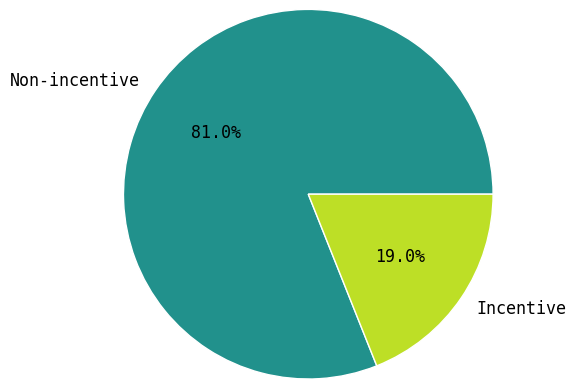

In [22]:
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('_mpl-gallery-nogrid')
plt.rcParams['font.family'] = ["monospace"]
plt.rcParams['font.size'] = 12

bn_colors = plt.get_cmap()(np.linspace(0.5, 0.9, 2))
num_non = bn_labels.count("non-incentive")
num_inc = bn_labels.count("incentive")

fig, ax = plt.subplots()
ax.pie([num_non, num_inc], colors=bn_colors, labels=["Non-incentive", "Incentive"], autopct='%1.1f%%', radius=1.25,
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
fig.show()

C:\Users\allie\AppData\Local\Temp\ipykernel_6244\4055259558.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


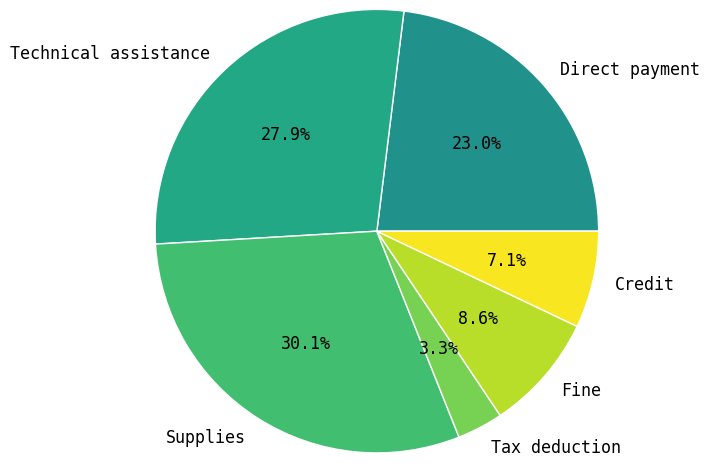

In [23]:
num_dp = mc_labels.count("Direct_payment")
num_ta = mc_labels.count("Technical_assistance")
num_su = mc_labels.count("Supplies")
num_td = mc_labels.count("Tax_deduction")
num_fn = mc_labels.count("Fine")
num_cr = mc_labels.count("Credit")

mc_colors = plt.get_cmap()(np.linspace(0.5, 0.99, 6))

fig, ax = plt.subplots()
ax.pie([num_dp, num_ta, num_su, num_td, num_fn, num_cr], labels=["Direct payment", "Technical assistance", "Supplies", "Tax deduction", "Fine", "Credit"], colors=mc_colors, autopct='%1.1f%%', radius=1.5,
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
fig.show()

C:\Users\allie\AppData\Local\Temp\ipykernel_6244\2609736636.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


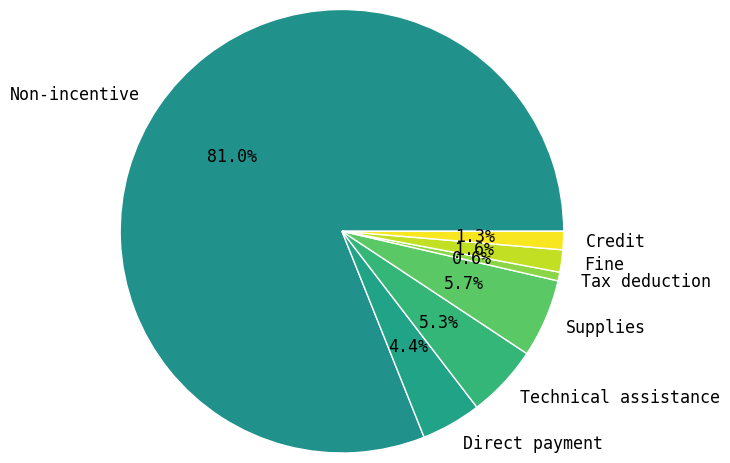

In [24]:
num_dp = labels.count("Direct_payment")
num_ta = labels.count("Technical_assistance")
num_su = labels.count("Supplies")
num_td = labels.count("Tax_deduction")
num_fn = labels.count("Fine")
num_cr = labels.count("Credit")
num_ni = labels.count("Non-Incentive")

mc_colors = plt.get_cmap()(np.linspace(0.5, 0.99, 7))

fig, ax = plt.subplots()
ax.pie([num_ni, num_dp, num_ta, num_su, num_td, num_fn, num_cr], labels=["Non-incentive", "Direct payment", "Technical assistance", "Supplies", "Tax deduction", "Fine", "Credit"], colors=mc_colors, autopct='%1.1f%%', radius=1.5,
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
fig.show()

# 4. Fine-Tuning Our Models

Nearly to the end of our pipeline! We ran our experiments outside of jupyter notebook (had to use python subprocesses to get around memory issues), but this section shows a simplified version of our experiments (i.e. 3 different dataset splits vs 10, showing only 1 model instead of all 4 tested).

First we construct and save a few different splits of our data into DatasetDicts containing Training, Testing, and Holdout sets.

In [ ]:
from classifier.finetune import load_labelintdcts, create_dsdict
int2label_dct, label2int_dct = load_labelintdcts()
sims = [3,6,9]
create_dsdict(sentences, labels, label2int_dct, amt=sims, save=True, output_dir=f"{cwd}/inputs")

Sanity Check: 269 incentive sentences and 1150 non-incentive sentences
Incentives: 0.18957011980267793; Non-Incentives: 0.8104298801973221
Sanity Check: 269 incentive sentences and 269 incentive labels

Round 3



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_3_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_3_mc

Round 6



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_6_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_6_mc

Round 9



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_9_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_9_mc


In [5]:
import torch
from classifier.finetune import finetune_incmodel
from datasets import DatasetDict
output_dir = cwd+"/outputs/models"
input_dir = cwd+"/inputs"

os.environ["WANDB_DISABLED"] = "true"

Now we run our finetuning step. Again, if you want to run the pipeline properly, you'll likely want to use the subprocess structure found in finetuning.py. We chose "sentence-transformers/paraphrase-xlm-r-multilingual-v1" for this notebook version.

In [6]:
# takes about 13min with our data
from classifier.finetune import load_labelintdcts
int2label_dct, label2int_dct = load_labelintdcts()
sims = [3,6,9]
for e in sims:
    bn_ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{e}_bn")
    mc_ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{e}_mc")
    for model in ["sentence-transformers/paraphrase-xlm-r-multilingual-v1"]:
        torch.cuda.empty_cache()
        hyperparams={
            "epochs":5, 
            "r":e,
            "lr":2e-5,
            "batch_size":16
            }
        finetune_incmodel(bn_ds, int2label_dct["bn"], label2int_dct["bn"], "bn", model_name=model, dev='cuda', output_dir=output_dir, hyperparams=hyperparams)
        print(f"\nSaved {model} binary model.")
        torch.cuda.empty_cache()
        hyperparams={
            "epochs":15, 
            "r":e,
            "lr":2e-5,
            "batch_size":16
            }
        finetune_incmodel(mc_ds, int2label_dct["mc"], label2int_dct["mc"], "mc", model_name=model, dev='cuda', output_dir=output_dir, hyperparams=hyperparams)
        print(f"\nSaved {model} multiclass model.")


Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing
Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Training


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

# 5. Evaluating

So now, with our models saved in our outputs folder, we can see their reported f1 scores and accuracy in the logs above-- but maybe we want to compare across traindevtest/traintestholdout splits (especially helpful when we were comparing different models.)

In [ ]:
import glob
import shutil
os.mkdir(output_dir+"/fting_A_bn")
os.mkdir(output_dir+"/fting_B_mc")
for modeldir in glob.glob(output_dir+"/p*"):
    fn = os.path.basename(modeldir)
    if "_bn_" in fn:
        shutil.move(modeldir, output_dir+f"/fting_A_bn/{fn}")
    elif "_mc_" in fn:
        shutil.move(modeldir, output_dir+f"/fting_B_mc/{fn}")

hyperparams={"epochs":5, "r":e, "lr":2e-5, "batch_size":16}
with open(output_dir+f"/fting_A_bn/run_details.json", "w", encoding="utf-8") as f:
    json.dump(hyperparams, f, ensure_ascii=False, indent=4)

hyperparams={"epochs":15, "r":e, "lr":2e-5, "batch_size":16}
with open(output_dir+f"/fting_B_MC/run_details.json", "w", encoding="utf-8") as f:
    json.dump(hyperparams, f, ensure_ascii=False, indent=4)

In [ ]:
# this code creates predictions for the holdout datasets, so it may take a couple minutes
from classifier.display_model import RunReporter

rr_bn = RunReporter(output_dir+"/fting_A_bn", 'bn')
rr_bn.load_model_reports("svm")
rr_bn.create_result_dfs()

rr_mc = RunReporter(output_dir+"/fting_B_mc", 'mc')
rr_mc.load_model_reports("svm")
rr_mc.create_result_dfs()

100%|██████████| 210/210 [00:02<00:00, 73.62it/s]


Encoding test sentences.


100%|██████████| 210/210 [00:02<00:00, 73.56it/s]


Encoding test sentences.


100%|██████████| 210/210 [00:02<00:00, 78.95it/s]


Encoding test sentences.


100%|██████████| 3/3 [00:19<00:00,  6.55s/it]


This last section shows how to view the evaluation data frames from the run reports-- but again, the values are different from our actual experiments run outside jupyter notebook.

In [13]:
print("BN overall\n", rr_bn.overall_df)
print("\nBN labels\n")
for i in range(len(rr_bn.id2label)):
    print(rr_bn.id2label[str(i)],"\n", rr_bn.label_df_dct[str(i)])

BN overall
          precision    recall  f1-score  accuracy  min_vloss
3         0.934803  0.933099  0.933801  0.933099        NaN
6         0.964789  0.964789  0.964789  0.964789        NaN
9         0.919628  0.919014  0.919305  0.919014        NaN
Average   0.939740  0.938967  0.939298  0.938967        NaN
SD        0.018764  0.019143  0.018971  0.019143        NaN

BN labels

non-incentive 
          precision    recall  f1-score
3         0.964912  0.952381  0.958606
6         0.978355  0.978355  0.978355
9         0.952174  0.948052  0.950108
Average   0.965147  0.959596  0.962356
SD        0.010690  0.013382  0.011833
incentive 
          precision    recall  f1-score
3         0.803571  0.849057  0.825688
6         0.905660  0.905660  0.905660
9         0.777778  0.792453  0.785047
Average   0.829003  0.849057  0.838798
SD        0.055218  0.046217  0.050105


In [14]:
print("MC overall\n", rr_mc.overall_df)
print("\nMC labels\n")
for i in range(len(rr_mc.id2label)):
    print(rr_mc.id2label[str(i)],"\n", rr_mc.label_df_dct[str(i)])

MC overall
          precision    recall  f1-score  accuracy  min_vloss
3         0.982311  0.981132  0.981026  0.981132        NaN
6         0.982583  0.981132  0.981205  0.981132        NaN
9         1.000000  1.000000  1.000000  1.000000        NaN
Average   0.988298  0.987421  0.987410  0.987421        NaN
SD        0.008275  0.008894  0.008902  0.008894        NaN

MC labels

Fine 
          precision  recall  f1-score
3              1.0     1.0       1.0
6              1.0     1.0       1.0
9              1.0     1.0       1.0
Average        1.0     1.0       1.0
SD             0.0     0.0       0.0
Supplies 
          precision    recall  f1-score
3              1.0  1.000000  1.000000
6              1.0  0.937500  0.967742
9              1.0  1.000000  1.000000
Average        1.0  0.979167  0.989247
SD             0.0  0.029463  0.015207
Technical_assistance 
          precision  recall  f1-score
3         0.937500     1.0  0.967742
6         1.000000     1.0  1.000000
9       